In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pylab
import re
import csv
from IPython.display import display, HTML  # To display correct tables
from pprint import pprint
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
cp = sns.color_palette()

def figsize(width=16, height=8):
    pylab.rcParams['figure.figsize'] = (width, height)

In [2]:
class Pi_rating:
    
    def __init__(self, c=None, l=None, gamma=None):
        self.c = c
        self.l = l
        self.gamma = gamma
    
    def _aux_phi(self,e):
        return self.c*np.log(e+1)
    
    def _aux_predict_difference(self,r):
        r2=np.abs(r)
        g_pred = np.exp(r2/self.c) - 1
        if r>0:
            return g_pred
        else:
            return (-g_pred)
    
    def _aux_error(self,g,r):
        g_pred = self._aux_predict_difference(r)
        return np.abs(g_pred-g)
    
    def pi_rating(self, games, init_rating=None):
        
        if self.c is None or self.l is None or self.gamma is None:
            raise ValueError("c, l or gamma attribute has not been instantiated.")
        games = games.sort_values(["season", "season_order"])
        teams = set(games["home_team"]) | set(games["away_team"])
        team_home_ratings = {}
        team_away_ratings = {}
        if init_rating is None:
            for team in teams:
                team_home_ratings[team] = 0
                team_away_ratings[team] = 0
        else:
            for team in teams:
                if team in init_rating:
                    team_ratings[team] = init_rating[team]
                else:
                    team_ratings[team] = 0
        # Process
        for games_index, row in games.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            # retrieve current values
            rhh = team_home_ratings[home_team]
            rha = team_away_ratings[home_team]
            rah = team_home_ratings[away_team]
            raa = team_away_ratings[away_team]
            # Calculate new values
            g = row["home_score"] - row["away_score"]
            g_pred_home_team = self._aux_predict_difference(rhh)
            g_pred_away_team = self._aux_predict_difference(raa)
            g_pred = g_pred_home_team - g_pred_away_team
            e = np.abs(g - g_pred)
            p = self._aux_phi(e)
            # Compute
            if g_pred < g:
                new_rhh = rhh + p*self.l
                new_rha = rha + (new_rhh - rhh)*self.gamma
                new_raa = raa - p*self.l
                new_rah = rah + (new_raa - raa)*self.gamma
            else :
                new_rhh = rhh - p*self.l
                new_rha = rha + (new_rhh - rhh)*self.gamma
                new_raa = raa + p*self.l
                new_rah = rah + (new_raa - raa)*self.gamma
            # Update
            # ----- Store result
            games.loc[games_index, "home_r_at_home"] = new_rhh
            games.loc[games_index, "home_r_away"] = new_rha
            games.loc[games_index, "away_r_at_home"] = new_rah
            games.loc[games_index, "away_r_away"] = new_raa
            games.loc[games_index, "prev_home_r_at_home"] = rhh
            games.loc[games_index, "prev_home_r_away"] = rha
            games.loc[games_index, "prev_away_r_at_home"] = rah
            games.loc[games_index, "prev_away_r_away"] = raa
            # ----- Update function helper variables
            team_home_ratings[home_team] = new_rhh
            team_away_ratings[home_team] = new_rha
            team_home_ratings[away_team] = new_rah
            team_away_ratings[away_team] = new_raa
        return games, team_home_ratings, team_away_ratings

    # New parameter: percentage of away wins among all the wins
    
    def awayshape(self, games):
        games = games.sort_values(["season", "season_order"])
        teams = set(games["home_team"]) | set(games["away_team"])
        prev_number_away_wins = {}
        prev_number_wins = {}
        prev_score = {}
        for team in teams:
            prev_number_away_wins[team] = 1
            prev_number_wins[team] = 1
            prev_score[team] = 0
        for games_index, row in games.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            h1 = prev_number_away_wins[home_team]
            h2 = prev_number_wins[home_team]
            a1 = prev_number_away_wins[away_team]
            a2 = prev_number_wins[away_team]
            rh = h1/h2
            ra = a1/a2
            home_s = prev_score[home_team]
            away_s = prev_score[away_team]
            games.loc[games_index, "home_awayshape"] = rh
            games.loc[games_index, "away_awayshape"] = ra
            games.loc[games_index, "home_number_of_wins"] = h2
            games.loc[games_index, "away_number_of_wins"] = a2
            games.loc[games_index, "home_number_of_wins_away"] = h1
            games.loc[games_index, "away_number_of_wins_away"] = a1
            games.loc[games_index, "home_prev_score"] = home_s
            games.loc[games_index, "away_prev_score"] = away_s
            if row["home_score"] < row["away_score"]:
                prev_number_away_wins[away_team]+= 1
                prev_number_wins[away_team]+= 1
            elif row["home_score"] > row ["away_score"]:
                prev_number_wins[home_team]+= 1
            prev_score[home_team] = row["home_score"]
            prev_score[away_team] = row["away_score"]
        return games
    
    
Pr=Pi_rating()
import numpy as np
from utils.gamesloader import Top14Loader
df = Top14Loader.get_consolidated_games()
c = 3
l = 0.035
gamma = 0.7
Pr.__init__(c,l,gamma)
df2, _, _ =Pr.pi_rating(df)
df2

season_order               home_team               away_team  \
185              0           USA Perpignan        Aviron Bayonnais   
184              1               Montauban        Stade Toulousain   
183              2           RC Toulonnais    Stade Francais Paris   
182              3     CS Bourgoin Jallieu                Clermont   
181              4                CA Brive  Montpellier Herault RC   
180              5      Biarritz Olympique       Castres Olympique   
179              6                    Albi               Racing 92   
178              7        Aviron Bayonnais    Stade Francais Paris   
177              8        Stade Toulousain                CA Brive   
176              9  Montpellier Herault RC           USA Perpignan   
175             10                Clermont               Montauban   
174             11      Biarritz Olympique                    Albi   
173             12           RC Toulonnais               Racing 92   
172             13       Castres Olympique     CS Bourgoin Jallieu   
171             14                CA Brive                Clermont   
170             15    Stade Francais Paris  Montpellier Herault RC   
169             16               Racing 92        Aviron Bayonnais   
168             17           USA Perpignan        Stade Toulousain   
167             18     CS Bourgoin Jallieu      Biarritz Olympique   
166             19                    Albi           RC Toulonnais   
165             20           USA Perpignan                CA Brive   
164             21        Stade Toulousain        Aviron Bayonnais   
163             22    Stade Francais Paris               Montauban   
162             23           RC Toulonnais                Clermont   
161             24  Montpellier Herault RC      Biarritz Olympique   
160             25     CS Bourgoin Jallieu               Racing 92   
159             26               Montauban           RC Toulonnais   
158             27               Racing 92           USA Perpignan   
157             28       Castres Olympique  Montpellier Herault RC   
156             29                CA Brive                    Albi   
...            ...                     ...                     ...   
1524           158                    Agen  Union Sportive Oyonnax   
1523           159  Montpellier Herault RC             La Rochelle   
1522           160               Racing 92           RC Toulonnais   
1521           161           RC Toulonnais  Montpellier Herault RC   
1520           162  Union Sportive Oyonnax                CA Brive   
1519           163         Section Paloise                    Agen   
1518           164                Clermont         Bordeaux Begles   
1517           165                    Lyon    Stade Francais Paris   
1516           166             La Rochelle       Castres Olympique   
1515           167        Stade Toulousain               Racing 92   
1514           168           RC Toulonnais       Castres Olympique   
1513           169  Union Sportive Oyonnax                    Lyon   
1512           170    Stade Francais Paris                CA Brive   
1511           171  Montpellier Herault RC         Section Paloise   
1510           172                    Agen                Clermont   
1509           173         Bordeaux Begles               Racing 92   
1508           174        Stade Toulousain             La Rochelle   
1507           175         Section Paloise           RC Toulonnais   
1506           176               Racing 92                    Agen   
1505           177                    Lyon  Montpellier Herault RC   
1504           178             La Rochelle    Stade Francais Paris   
1503           179                Clermont        Stade Toulousain   
1502           180       Castres Olympique  Union Sportive Oyonnax   
1501           181                CA Brive         Bordeaux Begles   
1500           182             Grenoble FC  Union Sportive Oyonnax   
1499           1

/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7394636015325671


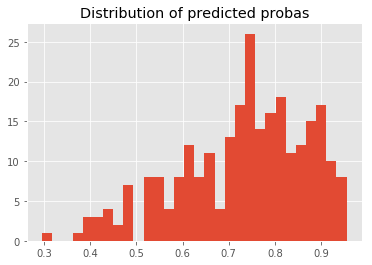

In [3]:
# Logistic regression taking as parameters all the ratings

df3 = df2[df2["season_order"] >= 42]
games_filtered = df3

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

whole_size = len(games_filtered.index)
train_size = int(whole_size * 0.8)
index = list(games_filtered.index)
np.random.seed(42)
np.random.shuffle(index)
train_index = index[:train_size]
test_index = index[train_size:]

train_df = games_filtered.loc[train_index]
test_df = games_filtered.loc[test_index]
lr.fit(train_df[["prev_home_r_at_home","prev_away_r_at_home","prev_home_r_away","prev_away_r_away",]], train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df[["prev_home_r_at_home","prev_away_r_at_home","prev_home_r_away","prev_away_r_away"]], test_df["home_score"] > test_df["away_score"]))

plt.hist(lr.predict_proba(test_df[["prev_home_r_at_home","prev_away_r_at_home","prev_home_r_away","prev_away_r_away"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

In [5]:
# Percentage of wins from home teams

sum(df3["home_score"]>df3["away_score"])/len(df3)

0.7340996168582375

In [6]:
# We predict that 93% of teams playing at home win

sum(lr.predict_proba(test_df[["prev_home_r_at_home","prev_away_r_away"]])[:, 1] > 0.5)/len(lr.predict_proba(test_df[["prev_home_r_at_home","prev_away_r_away"]])[:, 1])

0.9272030651340997

In [7]:
df4 = Pr.awayshape(df2)
df4

season_order               home_team               away_team  \
185              0           USA Perpignan        Aviron Bayonnais   
184              1               Montauban        Stade Toulousain   
183              2           RC Toulonnais    Stade Francais Paris   
182              3     CS Bourgoin Jallieu                Clermont   
181              4                CA Brive  Montpellier Herault RC   
180              5      Biarritz Olympique       Castres Olympique   
179              6                    Albi               Racing 92   
178              7        Aviron Bayonnais    Stade Francais Paris   
177              8        Stade Toulousain                CA Brive   
176              9  Montpellier Herault RC           USA Perpignan   
175             10                Clermont               Montauban   
174             11      Biarritz Olympique                    Albi   
173             12           RC Toulonnais               Racing 92   
172             13       Castres Olympique     CS Bourgoin Jallieu   
171             14                CA Brive                Clermont   
170             15    Stade Francais Paris  Montpellier Herault RC   
169             16               Racing 92        Aviron Bayonnais   
168             17           USA Perpignan        Stade Toulousain   
167             18     CS Bourgoin Jallieu      Biarritz Olympique   
166             19                    Albi           RC Toulonnais   
165             20           USA Perpignan                CA Brive   
164             21        Stade Toulousain        Aviron Bayonnais   
163             22    Stade Francais Paris               Montauban   
162             23           RC Toulonnais                Clermont   
161             24  Montpellier Herault RC      Biarritz Olympique   
160             25     CS Bourgoin Jallieu               Racing 92   
159             26               Montauban           RC Toulonnais   
158             27               Racing 92           USA Perpignan   
157             28       Castres Olympique  Montpellier Herault RC   
156             29                CA Brive                    Albi   
...            ...                     ...                     ...   
1524           158                    Agen  Union Sportive Oyonnax   
1523           159  Montpellier Herault RC             La Rochelle   
1522           160               Racing 92           RC Toulonnais   
1521           161           RC Toulonnais  Montpellier Herault RC   
1520           162  Union Sportive Oyonnax                CA Brive   
1519           163         Section Paloise                    Agen   
1518           164                Clermont         Bordeaux Begles   
1517           165                    Lyon    Stade Francais Paris   
1516           166             La Rochelle       Castres Olympique   
1515           167        Stade Toulousain               Racing 92   
1514           168           RC Toulonnais       Castres Olympique   
1513           169  Union Sportive Oyonnax                    Lyon   
1512           170    Stade Francais Paris                CA Brive   
1511           171  Montpellier Herault RC         Section Paloise   
1510           172                    Agen                Clermont   
1509           173         Bordeaux Begles               Racing 92   
1508           174        Stade Toulousain             La Rochelle   
1507           175         Section Paloise           RC Toulonnais   
1506           176               Racing 92                    Agen   
1505           177                    Lyon  Montpellier Herault RC   
1504           178             La Rochelle    Stade Francais Paris   
1503           179                Clermont        Stade Toulousain   
1502           180       Castres Olympique  Union Sportive Oyonnax   
1501           181                CA Brive         Bordeaux Begles   
1500           182             Grenoble FC  Union Sportive Oyonnax   
1499           1

/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7432950191570882


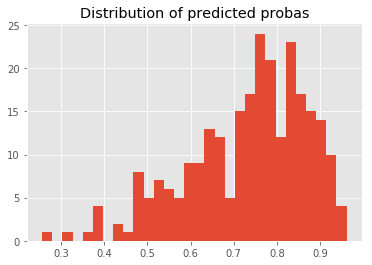

In [8]:
df5 = df4[df4["season_order"] >= 42]
games_filtered = df5

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

whole_size = len(games_filtered.index)
train_size = int(whole_size * 0.8)
index = list(games_filtered.index)
np.random.seed(42)
np.random.shuffle(index)
train_index = index[:train_size]
test_index = index[train_size:]

train_df = games_filtered.loc[train_index]
test_df = games_filtered.loc[test_index]
lr.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]], train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]], test_df["home_score"] > test_df["away_score"]))

plt.hist(lr.predict_proba(test_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

0.7432950191570882


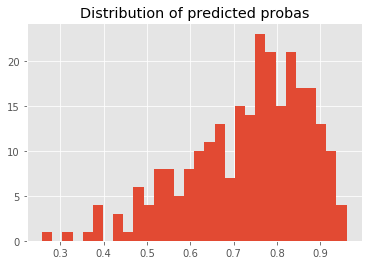

In [9]:
# Logistic regression with penaly L1, logistic lasso

from sklearn.linear_model import LogisticRegression
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]], train_df["home_score"] > train_df["away_score"])
print(log.score(test_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]], test_df["home_score"] > test_df["away_score"]))

plt.hist(log.predict_proba(test_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

In [10]:
# Lasso

from sklearn.linear_model import Lasso
ls=Lasso()
ls.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]],train_df["home_score"] > train_df["away_score"])
print(ls.coef_)

[ 0.         -0.         -0.         -0.          0.00109311 -0.00081886
  0.         -0.          0.         -0.        ]


0.7241379310344828


/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


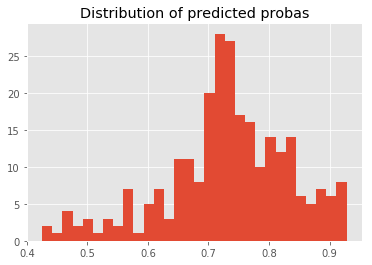

In [11]:
# Logistic regression without the parameters annulated by lasso

df5 = df4[df4["season_order"] >= 42]
games_filtered = df5

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

whole_size = len(games_filtered.index)
train_size = int(whole_size * 0.8)
index = list(games_filtered.index)
np.random.seed(42)
np.random.shuffle(index)
train_index = index[:train_size]
test_index = index[train_size:]

train_df = games_filtered.loc[train_index]
test_df = games_filtered.loc[test_index]
lr.fit(train_df[["home_number_of_wins","away_number_of_wins"]], train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df[["home_number_of_wins","away_number_of_wins"]], test_df["home_score"] > test_df["away_score"]))

plt.hist(lr.predict_proba(test_df[["home_number_of_wins","away_number_of_wins"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

0.9583333333333334


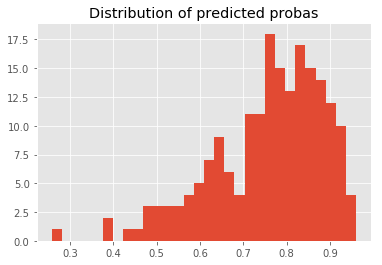

In [19]:
#Test on games where the home team won

test_df_home = test_df[test_df["home_score"] > test_df["away_score"]]

from sklearn.linear_model import LogisticRegression
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]], train_df["home_score"] > train_df["away_score"])
print(log.score(test_df_home[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]], test_df_home["home_score"] > test_df_home["away_score"]))

plt.hist(log.predict_proba(test_df_home[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()


In [1]:
#Test on games where the away team won

test_df_away = test_df[test_df["away_score"] > test_df["home_score"]]

from sklearn.linear_model import LogisticRegression
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]], train_df["home_score"] > train_df["away_score"])
print(log.score(test_df_away[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]], test_df_away["home_score"] > test_df_away["away_score"]))

plt.hist(log.predict_proba(test_df_away[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away","home_prev_score","away_prev_score"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()


NameError: name 'test_df' is not defined